In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.nn.parameter import Parameter

# 00 Function Definition

## Data Generation

In [2]:
def gen_data(num_samples, noise=0):
  points = []
  labels = []

  for i in range(num_samples):
    x = np.random.uniform()
    y = np.random.uniform()
    
    nx = np.random.uniform(low=-noise/100, high=noise/100)
    ny = np.random.uniform(low=-noise/100, high=noise/100)

    if(-0.7 * x - y + 0.8 > 0 and 0.9 * x - y + 0.1 < 0):
        if noise > 0:
            points.append([x+nx, y+ny, 0])
            labels.append(0)
        else:
            points.append([x, y, 0])
            labels.append(0)
    else:
        if noise > 0:
            points.append([x+nx, y+ny, 1])
            labels.append(1)
        else:
            points.append([x, y, 1])
            labels.append(1)
          
  return points, labels

## Squashing Function

In [3]:
class SquashingFunction(nn.Module):
    '''
    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input
    Examples:
        m = squashing(beta=25)
        input = torch.randn(2)
        output = m(input)

        Input/Output have same shape:
        input.shape
        output.shape
    '''
    def __init__(self, beta=0.1):
        '''
        Init method.
        '''
        super(SquashingFunction, self).__init__()
        
        self.alpha = 0.5
        self.lam = 1.0
        
        self.beta = Parameter(torch.tensor(beta)) # create a tensor out of beta
        #print("Beta Wert", self.beta)
            
        self.beta.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        #print("Beta:", self.beta.data.item())
        # define beta global for pandas print
        global betas 
        betas = self.beta.data.item()
        return (1/(self.lam * self.beta)) * torch.log( (1+torch.exp(self.beta*(x-(self.alpha-(self.lam/2)))) ) / (1+torch.exp(self.beta*(x-(self.alpha+(self.lam/2))))) )

## Network

In [4]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()

        self.linear_layer_1 = nn.Linear(2, 1)
        self.linear_layer_2 = nn.Linear(2, 1)
        
        self.activation1 = SquashingFunction()
        self.activation2 = SquashingFunction()

        # AND Gate
        self.and_layer = nn.Linear(in_features=2, out_features=1)

        self.and_layer.weight.requires_grad = False
        self.and_layer.bias.requires_grad  = False
        with torch.no_grad():
            self.and_layer.weight.fill_(1.0)
            self.and_layer.bias.fill_(-1.0)

    def forward(self, X):
        self.z1 = self.linear_layer_1(X)
        self.z1 = self.activation1(self.z1)      # activation function

        self.z2 = self.linear_layer_2(X)
        self.z2 = self.activation1(self.z2)      # activation function

        
        global betaAnd
        global betaGerade
        betaGerade = betas


        self.out = self.and_layer(torch.cat((self.z1, self.z2), 1))
        self.out = self.activation2(self.out)
        betaAnd = betas

        
        return self.out

# 01 Data Preparation

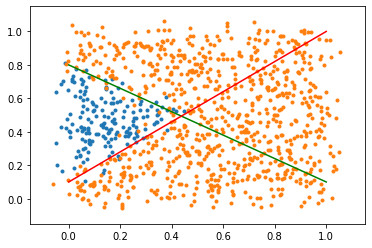

In [5]:
points, labels = gen_data(1000, 7)


plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')

# plot lines
x = torch.linspace(0,1)
plt.plot(x, -(0.7*x-0.8), 'green')   # y = -0.7*x+0.8 => -0.7*x-y+0.8 > 0
plt.plot(x, -(-0.9*x-0.1), 'red')    # y = 0.9*x+0.1 => 0.9*x-y+0.1 < 0 

plt.ylim(-0.15, 1.15)
plt.xlim(-0.15, 1.15)
plt.show() 

In [6]:

# training set
trainX = torch.Tensor([[i[0],i[1]] for i in points]).float()
trainY = torch.Tensor([[i[2]] for i in points]).float()

# 02 Network Preparation

Epoch: 0
  Loss: 0.25911450386047363
  z1: y = -((-0.5357 * x + 0.3846) / 0.1014)
  z2: y = -((-0.073 * x + -0.6404) / -0.1942)


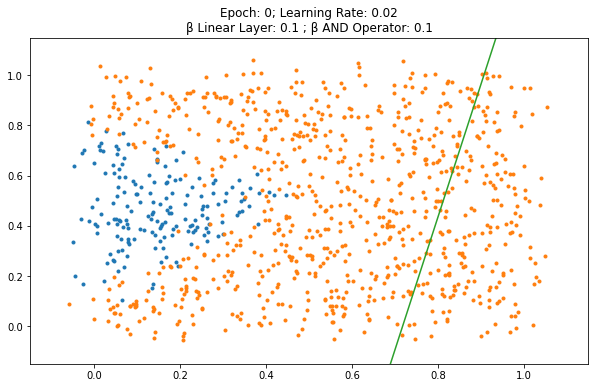

Epoch: 50
  Loss: 0.14930905401706696
  z1: y = -((-1.1608 * x + -0.2292) / -0.5098)
  z2: y = -((-0.6851 * x + -1.2403) / -0.7876)


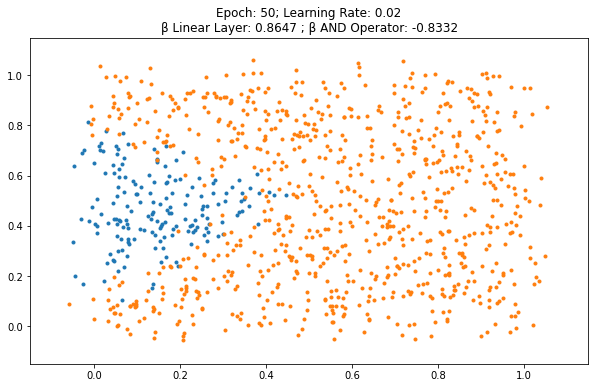

Epoch: 100
  Loss: 0.13570629060268402
  z1: y = -((-1.856 * x + -0.0544) / -0.2493)
  z2: y = -((-1.2188 * x + -1.347) / -0.7775)


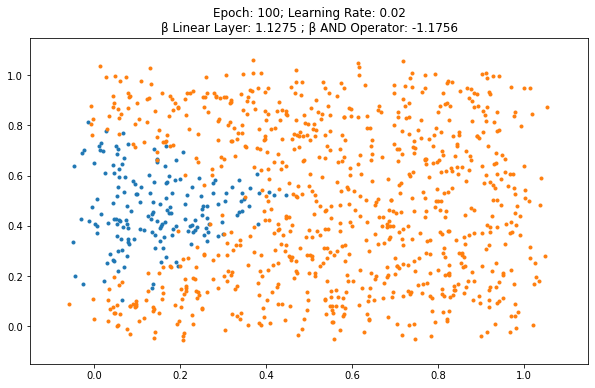

Epoch: 150
  Loss: 0.1239335834980011
  z1: y = -((-2.7324 * x + 0.9207) / 0.5638)
  z2: y = -((-1.6213 * x + -0.6626) / -0.048)


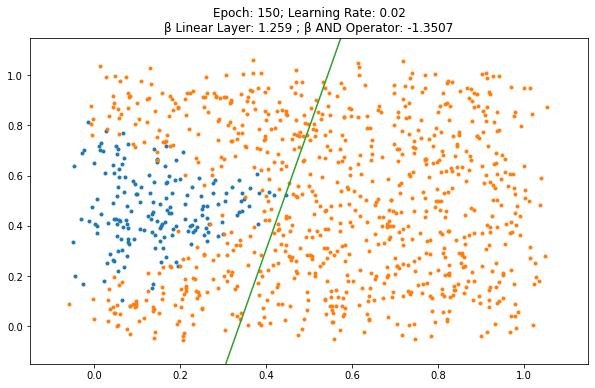

Epoch: 200
  Loss: 0.10252400487661362
  z1: y = -((-3.8449 * x + 1.4455) / 0.2372)
  z2: y = -((-2.5418 * x + 0.7489) / 0.4374)


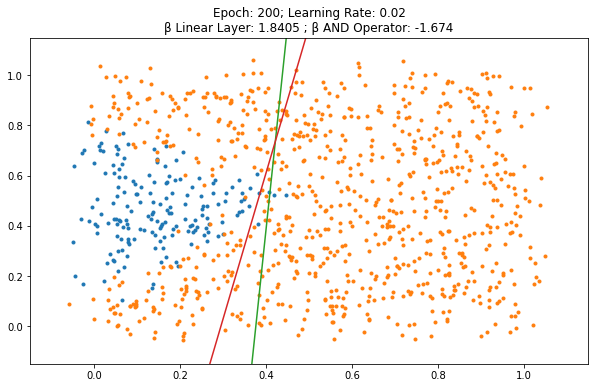

Epoch: 250
  Loss: 0.09520401060581207
  z1: y = -((-4.2642 * x + 1.7735) / -0.2136)
  z2: y = -((-3.3568 * x + 1.3049) / 0.0667)


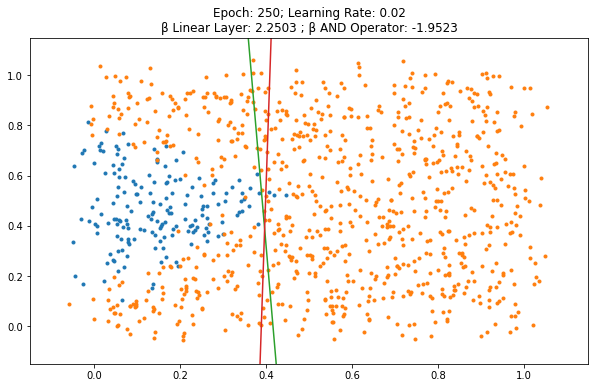

Epoch: 300
  Loss: 0.09375402331352234
  z1: y = -((-4.35 * x + 1.9495) / -0.592)
  z2: y = -((-3.6277 * x + 1.3057) / 0.352)


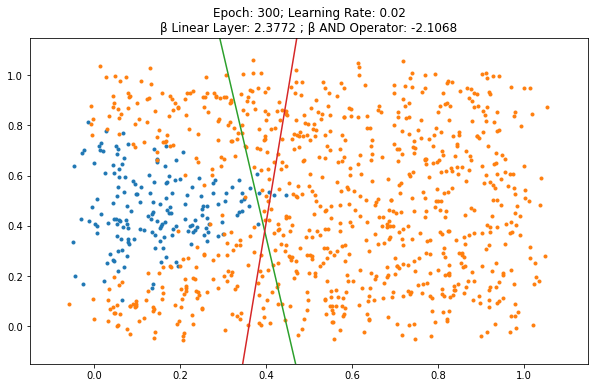

Epoch: 350
  Loss: 0.08723954111337662
  z1: y = -((-4.2373 * x + 2.39) / -1.6635)
  z2: y = -((-3.888 * x + 0.9078) / 1.813)


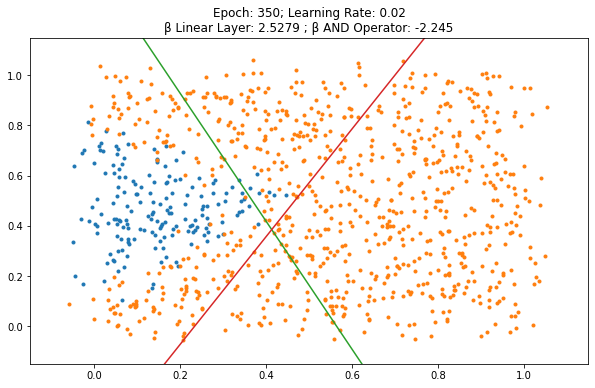

Epoch: 400
  Loss: 0.07085970044136047
  z1: y = -((-4.0021 * x + 3.3275) / -3.1678)
  z2: y = -((-4.2544 * x + 0.2957) / 3.7551)


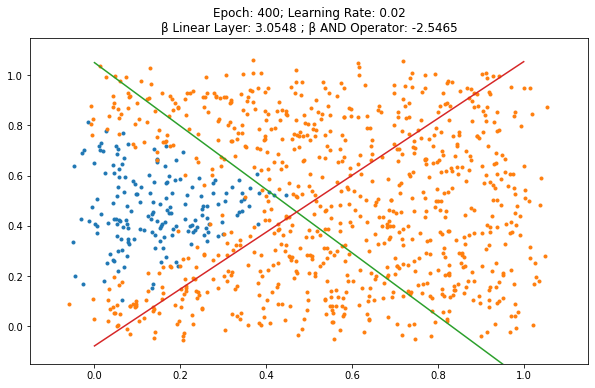

Epoch: 450
  Loss: 0.05888865515589714
  z1: y = -((-3.9937 * x + 3.9336) / -4.0724)
  z2: y = -((-4.6435 * x + -0.0118) / 5.0221)


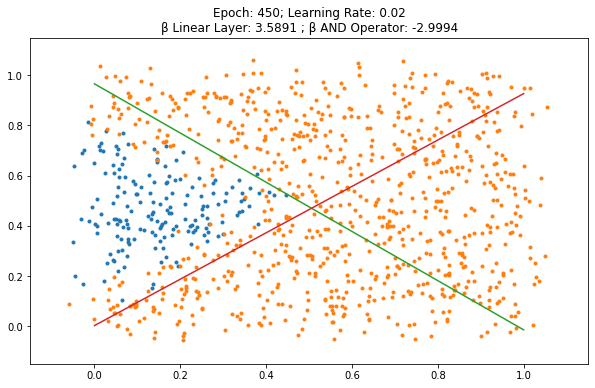

Epoch: 500
  Loss: 0.05142635107040405
  z1: y = -((-4.0212 * x + 4.3289) / -4.6433)
  z2: y = -((-5.0105 * x + -0.1852) / 5.8292)


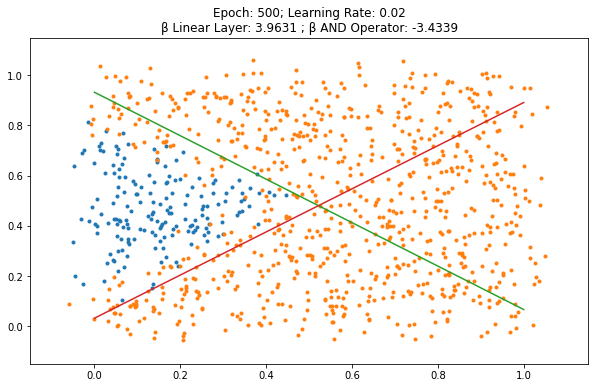

Epoch: 550
  Loss: 0.04653841257095337
  z1: y = -((-4.0592 * x + 4.6275) / -5.0723)
  z2: y = -((-5.3227 * x + -0.3032) / 6.4092)


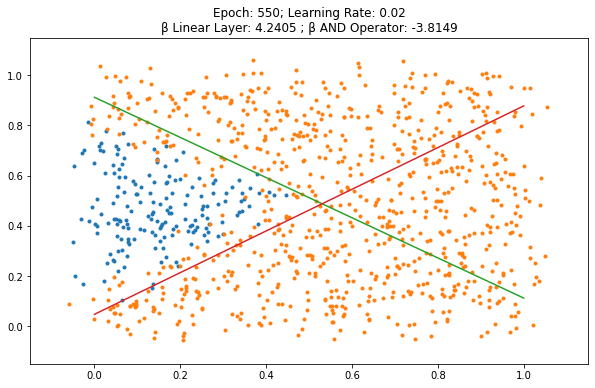

Epoch: 600
  Loss: 0.04316204413771629
  z1: y = -((-4.1253 * x + 4.8622) / -5.4017)
  z2: y = -((-5.5806 * x + -0.3948) / 6.8679)


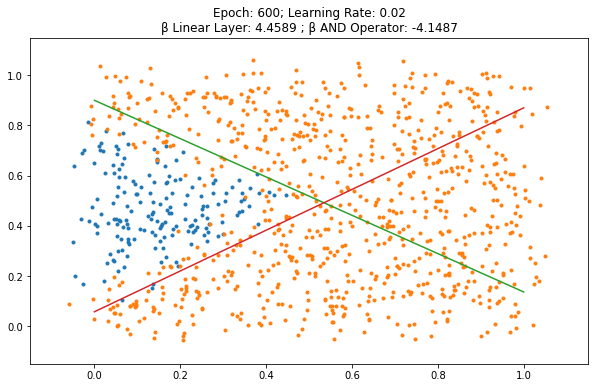

Epoch: 650
  Loss: 0.040706489235162735
  z1: y = -((-4.2006 * x + 5.0555) / -5.6683)
  z2: y = -((-5.7987 * x + -0.4713) / 7.2524)


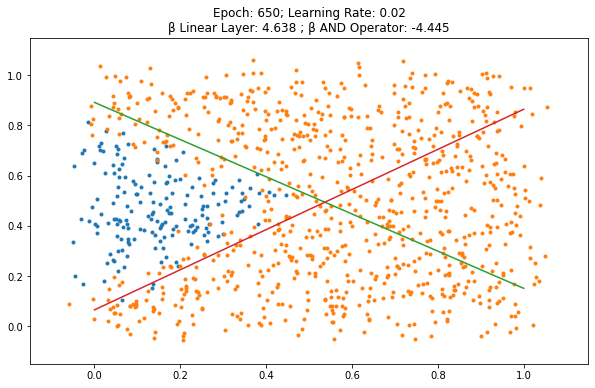

Epoch: 700
  Loss: 0.03884506970643997
  z1: y = -((-4.2766 * x + 5.2189) / -5.891)
  z2: y = -((-5.9911 * x + -0.5367) / 7.5858)


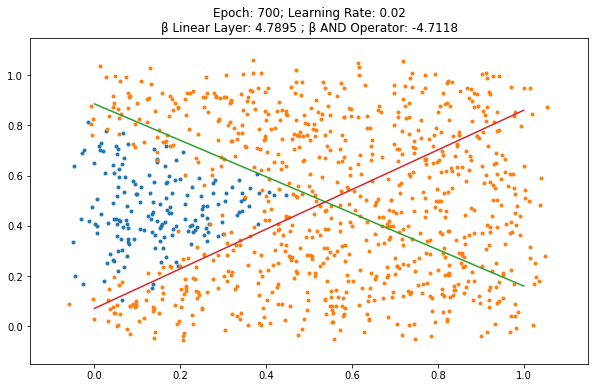

Epoch: 750
  Loss: 0.03738711401820183
  z1: y = -((-4.3494 * x + 5.3593) / -6.0806)
  z2: y = -((-6.1664 * x + -0.5935) / 7.8817)


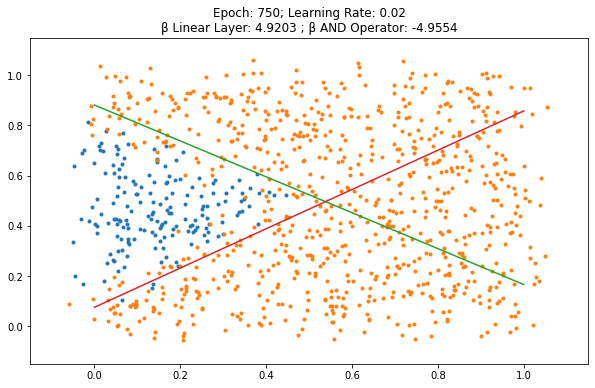

In [14]:
learning_rate = 0.02

network = SimpleNetwork()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for epoch in range(751):
    predictions = network(trainX)
    loss = criterion(predictions, trainY)

    optimizer.zero_grad()
    loss.backward()         # calculate gradient
    optimizer.step()        # update weights

    # output
    z1 = -((network.linear_layer_1.weight.squeeze()[0] * x + network.linear_layer_1.bias[0]) / network.linear_layer_1.weight.squeeze()[1])
    z2 = -((network.linear_layer_2.weight.squeeze()[0] * x + network.linear_layer_2.bias[0]) / network.linear_layer_2.weight.squeeze()[1])

    if epoch % 50 == 0:
        print(f'Epoch: {epoch}')
        print(f'  Loss: {loss}')
        print(f'  z1: y = -(({round(float(network.linear_layer_1.weight.squeeze()[0]), 4)} * x + {round(float(network.linear_layer_1.bias[0]),4)}) / {round(float(network.linear_layer_1.weight.squeeze()[1]), 4)})')
        print(f'  z2: y = -(({round(float(network.linear_layer_2.weight.squeeze()[0]), 4)} * x + {round(float(network.linear_layer_2.bias[0]),4)}) / {round(float(network.linear_layer_2.weight.squeeze()[1]), 4)})')

        plt.figure(figsize=(10,6))
        plt.plot([i[0] for i in points if i[2] == 0], [i[1] for i in points if i[2] == 0], '.')
        plt.plot([i[0] for i in points if i[2] == 1], [i[1] for i in points if i[2] == 1], '.')
        plt.plot(x.numpy(), z1.detach().numpy(), '-')
        plt.plot(x.numpy(), z2.detach().numpy(), '-')
        plt.ylim(-0.15, 1.15)
        plt.xlim(-0.15, 1.15)
        plt.title(f'Epoch: {epoch}; Learning Rate: {learning_rate}\nβ Linear Layer: {round(betaGerade,4)} ; β AND Operator: {round(betaAnd,4)}')
        #plt.savefig(f'./drive/My Drive/plot/{epoch}.png', dpi=300, transparent=True, bbox_inches='tight')
        plt.show()
